In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Import Column names for dataset
data_headers = pd.read_csv("part-1-dataset/field_names.txt", names = ["Name"])
#data_headers.head()

In [3]:
data = pd.read_csv("part-1-dataset/breast-cancer.csv", names = data_headers["Name"])

In [4]:
data.shape

(569, 32)

# Data Cleaning
1. Check for Null values
2. Check that data types and ranges make sense

In [5]:
data.isnull().sum().sum()
# Note: since the output is 0, there are no null values throughout the dataset

0

In [6]:
data.dtypes
print(data.columns.values)
data.head()


['ID' 'diagnosis' 'radius_mean' 'radius_sd_error' 'radius_worst'
 'texture_mean' 'texture_sd_error' 'texture_worst' 'perimeter_mean'
 'perimeter_sd_error' 'perimeter_worst' 'area_mean' 'area_sd_error'
 'area_worst' 'smoothness_mean' 'smoothness_sd_error' 'smoothness_worst'
 'compactness_mean' 'compactness_sd_error' 'compactness_worst'
 'concavity_mean' 'concavity_sd_error' 'concavity_worst'
 'concave_points_mean' 'concave_points_sd_error' 'concave_points_worst'
 'symmetry_mean' 'symmetry_sd_error' 'symmetry_worst'
 'fractal_dimension_mean' 'fractal_dimension_sd_error'
 'fractal_dimension_worst']


,ID,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
data.diagnosis.unique()

array(['M', 'B'], dtype=object)

### Comments: 
The data does not need to be cleaned. Data types seem to be fine as well. Rightfully, ID should be an object and not an integer - however, as long as we take care not to include it in the analysis, it is ok.

We will be looking at the diagnosis of "M" or "B". Later on, we should hot-encode this variable so that we can run a model on it (M being 1, B being 0)

# Data Exploration
1. Obtain Mean and Median of (Smoothness, Compactness)
- We will do so using smoothness_mean and compactness_mean

In [8]:
data[["diagnosis", "smoothness_mean", "compactness_mean"]].groupby("diagnosis").agg(["mean", "median"]).reset_index()

diagnosis smoothness_mean         compactness_mean         
                       mean  median             mean   median
0         B        2.000321  1.8510         0.021438  0.01631
1         M        4.323929  3.6795         0.032281  0.02859

### Comments:

1. Benign Tumours tend to have a smaller value of smoothness (<2 vs 4). This can be seem from the mean/median. Malignant tumours tend to have higher values of smoothness

2. Benign Tumours have smaller values of Compactness (~ 0.02) as compared to Malign Tumours (>0.02)

**Bootstrapping the data to produce samples to estimate mean, median**</br>
Approach: 
1. Sample N datapoints w replacement
2. Calculate the mean / median for each sample
3. Calculate the overall mean value of the samples

In [9]:
def bs_sample(data, N = data.shape[0]//5, x = 1000):
    # N: Size of sample
    # x: number of data samples
    import random
    smooth = pd.DataFrame()
    compact = pd.DataFrame()
    
    print("Size of samples:", N)
    print("No. samples:",x)
    temp = data.reset_index(drop = True)
    
    for i in range(x):
        temp_rand = temp.iloc[random.sample(range(temp.shape[0]), N)]
        
        smooth = smooth.append(temp_rand[["diagnosis", "smoothness_mean"]].groupby("diagnosis").agg(["mean", "median"]).reset_index())
        compact = compact.append(temp_rand[["diagnosis", "compactness_mean"]].groupby("diagnosis").agg(["mean", "median"]).reset_index())

    smooth.columns = ["diagnosis", "smooth_mean", "smooth_median"]
    smooth = smooth.groupby("diagnosis").mean().reset_index()

    compact.columns = ["diagnosis", "compact_mean", "compact_median"]
    compact = compact.groupby("diagnosis").mean().reset_index()
    
    return pd.merge(smooth, compact)

In [10]:
bs_sample(data, N = 200, x = 500)

Size of samples: 200
No. samples: 500


,diagnosis,smooth_mean,smooth_median,compact_mean,compact_median
0,B,1.999225,1.852635,0.021524,0.016263
1,M,4.315857,3.687282,0.032288,0.028615


import seaborn as sn

In [11]:
data.columns[2:]

Index(['radius_mean', 'radius_sd_error', 'radius_worst', 'texture_mean',
       'texture_sd_error', 'texture_worst', 'perimeter_mean',
       'perimeter_sd_error', 'perimeter_worst', 'area_mean', 'area_sd_error',
       'area_worst', 'smoothness_mean', 'smoothness_sd_error',
       'smoothness_worst', 'compactness_mean', 'compactness_sd_error',
       'compactness_worst', 'concavity_mean', 'concavity_sd_error',
       'concavity_worst', 'concave_points_mean', 'concave_points_sd_error',
       'concave_points_worst', 'symmetry_mean', 'symmetry_sd_error',
       'symmetry_worst', 'fractal_dimension_mean',
       'fractal_dimension_sd_error', 'fractal_dimension_worst'],
      dtype='object')

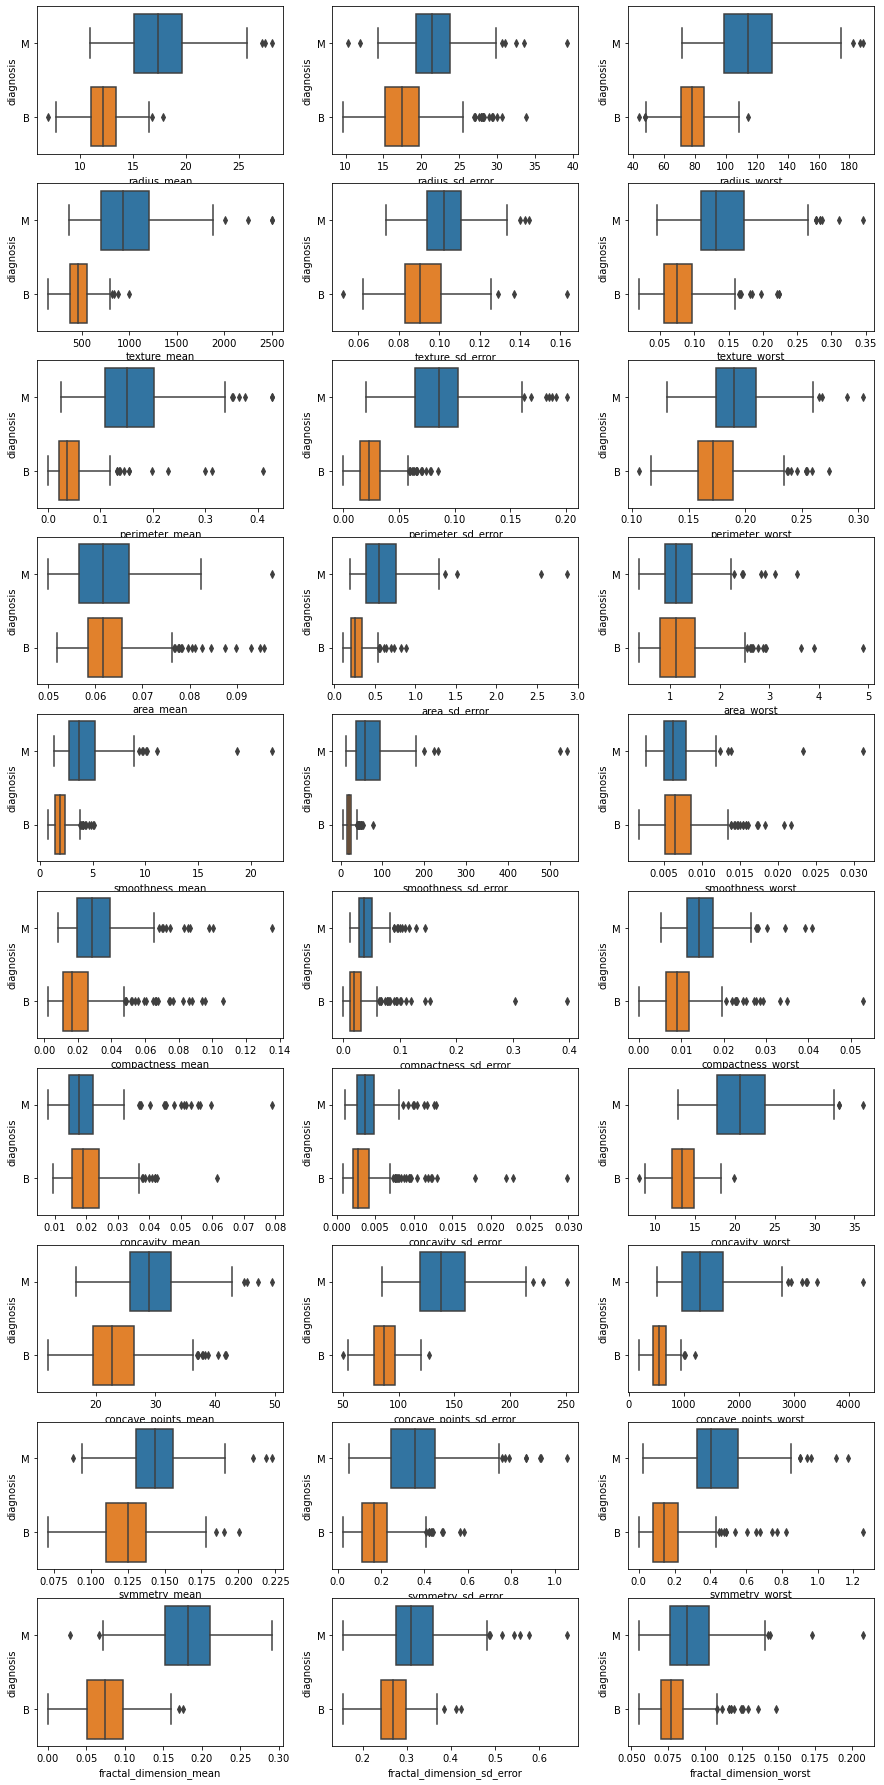

In [12]:
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
plt.rcParams["figure.figsize"] = [15,32]
fig, axes = plt.subplots(ncols=3, nrows=10)
cols = data.columns[2:]
for i , ax in zip(range(len(cols)), axes.flat):
    sn.boxplot(data=data, x = cols[i], y = 'diagnosis', ax = ax)#.set(title=cols[i])
plt.show()

### Comments
Based on the various box plots, we think that there are differences in the following variables for Benign and Malignant tumours:
- radius
- texture
- perimeter
- concave
- symmetry
- fractal dimension

Also, radius and perimeter are most likely related (as these are distance/length measures)

In [13]:
data[['radius_mean', 'perimeter_mean']].corr()
data[['radius_mean', 'perimeter_mean', "texture_mean", "concavity_mean"]].corr()

,radius_mean,perimeter_mean,texture_mean,concavity_mean
radius_mean,1.000000,0.676764,0.987357,-0.104321
perimeter_mean,0.676764,1.000000,0.685983,0.178009
texture_mean,0.987357,0.685983,1.000000,-0.072497
concavity_mean,-0.104321,0.178009,-0.072497,1.000000


# Modelling
We will test out 2 classification methods. For simplicity, we try:
1. Logistic Regression; and 
2. Random Forest

Based on the data, we seem to have a good balance of diagnosis so we do not need to sample

In [14]:
data.iloc[:, 0:2].groupby('diagnosis').count()

,ID
diagnosis,
B,357
M,212


### Discussion on Models:

| Model | Pros|Cons|
|------|------|------|
|Logistic Regression|Easy to interpret with coefficients that can used for explainability|Variables need to be scaled, and we need to ensure that the data is not multi-collinear.|
|Decision Tree|Easy to implement and understand. Data does not need to follow a distribution.|Trees can be susceptible to imbalance in data, causing erronous predictions if the labels are skewed to 1 class|


### Controlling for Overfitting:

In the dataset, the labels are roughly in the ratio 2:3. This is a pretty decent balance and we should not need to under/oversample to fix the balance of the data.

To prevent overfitting, we will
1. Ensure a 7:3 train to test ratio, so that the model is tested on a blind test set; or
2. Perform k-fold cross validation.</br>

For this demo, we will do approach 2.

In [ ]:
## Logistic Regression Prep
